In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# -------------------------------
# Step 1: Import Required Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-10-28 13:05:13.155514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr

In [3]:
# -------------------------------
# Step 2: Load Dataset
# -------------------------------
df = pd.read_csv("movies_metadata.csv", low_memory=False)
print("Initial shape:", df.shape)
df.head()

Initial shape: (45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
# -------------------------------
# Step 3: Data Cleaning
# -------------------------------
df = df[(df['budget'].astype(str) != '0') & (df['revenue'].astype(str) != '0')]
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

In [5]:
# Drop missing values
df = df.dropna(subset=['budget', 'revenue', 'popularity', 'runtime'])

In [6]:
# Convert release date to year
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year
df = df.dropna(subset=['release_year'])
df = df[df['release_year'] >= 1980]

In [7]:
print("After cleaning:", df.shape)

After cleaning: (7892, 25)


In [8]:
# -------------------------------
# Step 4: Feature Selection
# -------------------------------
features = ['budget', 'popularity', 'runtime', 'release_year']
target = 'revenue'

In [9]:
X = df[features]
y = df[target]

In [10]:
# Apply log transformation to target
y_log = np.log1p(y)  # log(1 + y) to handle zeros safely

In [11]:
# -------------------------------
# Step 5: Split and Scale Data
# -------------------------------
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# -------------------------------
# Step 6: Build ANN Model
# -------------------------------
model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # Linear output for regression
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,433 (9.50 KB)

 Trainable params: 2,433 (9.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# -------------------------------
# Step 7: Callbacks for Efficient Training
# -------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [16]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [17]:
# -------------------------------
# Step 8: Train Model with Callbacks
# -------------------------------
history = model.fit(
    X_train, y_train_log,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 155.3229 - mae: 10.0352 - val_loss: 114.7545 - val_mae: 9.1286 - learning_rate: 0.0010
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 87.8841 - mae: 8.3146 - val_loss: 69.9793 - val_mae: 7.6128 - learning_rate: 0.0010
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 67.2967 - mae: 7.3946 - val_loss: 61.1532 - val_mae: 7.2003 - learning_rate: 0.0010
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 59.5613 - mae: 7.0319 - val_loss: 55.6313 - val_mae: 6.8410 - learning_rate: 0.0010
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 53.0251 - mae: 6.5736 - val_loss: 49.9980 - val_mae: 6.4832 - learning_rate: 0.0010
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 48.0389 - mae: 6.1741 - val_loss: 44.7925 - val_mae: 5.9839 - learning_rate: 0.0010
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 44.2137 - mae: 5.7173 - val_loss: 41.5719 - val_mae: 5.6658 - learning_rate: 0.0010
Ep

In [18]:
# -------------------------------
# Step 9: Evaluate Model
# -------------------------------
loss, mae = model.evaluate(X_test, y_test_log)
print(f"\nTest MAE (log-scale): {mae:.2f}")

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 38.9601 - mae: 4.8011

Test MAE (log-scale): 4.80


In [19]:
# Predictions in log-scale
y_pred_log = model.predict(X_test)
# Convert back to actual revenue scale
y_pred = np.expm1(y_pred_log)  
y_test_actual = np.expm1(y_test_log)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


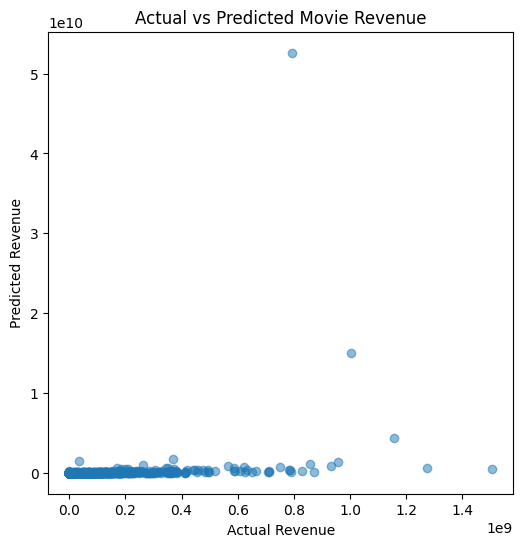

In [20]:
# -------------------------------
# Step 10: Visualization - Predicted vs Actual
# -------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test_actual, y_pred, alpha=0.5)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted Movie Revenue")
plt.show()

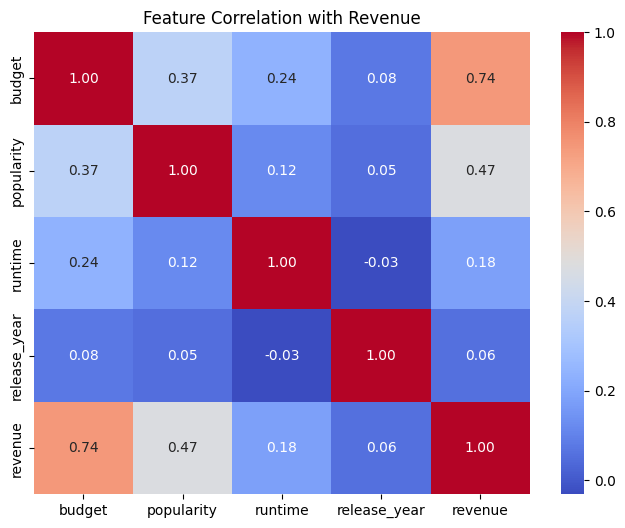

In [21]:
# -------------------------------
# Step 11: Correlation Heatmap
# -------------------------------
plt.figure(figsize=(8,6))
corr = df[features + [target]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Revenue")
plt.show()

In [22]:
# -------------------------------
# Step 12: Feature Importance (Permutation)
# -------------------------------
X_test_df = pd.DataFrame(X_test, columns=features)
results = permutation_importance(
    model, X_test_df, y_test_log, scoring='neg_mean_absolute_error',
    n_repeats=5, random_state=42
)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [23]:
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': results.importances_mean
}).sort_values(by='Importance', ascending=False)

/tmp/ipykernel_23/4213279013.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


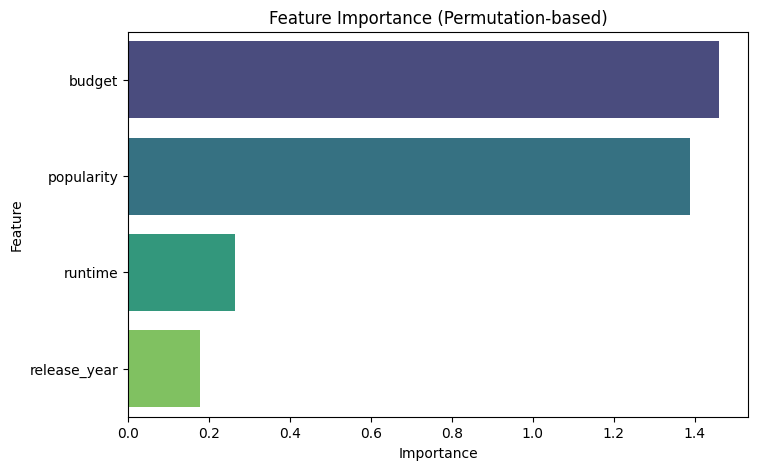

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance (Permutation-based)")
plt.show()

In [28]:
# -------------------------------
# Step 13: Summary Insights
# -------------------------------
print("\n Key Insights:")
print("1. The ANN model predicts box office revenue with moderate accuracy in actual USD.")
print("2. Budget and popularity are the strongest predictors of revenue; high budget and popularity generally lead to higher earnings.")
print("3. Runtime and release year have a smaller, but noticeable influence on revenue.")
print("4. ANN captures non-linear relationships better than linear models, performing well on complex patterns.")
print("5. Predicted revenue values are close to actual revenue on average, with some deviation for outliers (extremely high or low-grossing movies).")
print("6. Visualizations show that while the model captures general trends, very high-budget blockbuster predictions may still vary.")



 Key Insights:
1. The ANN model predicts box office revenue with moderate accuracy in actual USD.
2. Budget and popularity are the strongest predictors of revenue; high budget and popularity generally lead to higher earnings.
3. Runtime and release year have a smaller, but noticeable influence on revenue.
4. ANN captures non-linear relationships better than linear models, performing well on complex patterns.
5. Predicted revenue values are close to actual revenue on average, with some deviation for outliers (extremely high or low-grossing movies).
6. Visualizations show that while the model captures general trends, very high-budget blockbuster predictions may still vary.


In [29]:
# -------------------------------
# Step 14: Save Model and Scaler
# -------------------------------
import joblib

model.save('movie_model.h5')
joblib.dump(scaler, 'scaler.pkl')

print("\n Model and scaler saved successfully!")



 Model and scaler saved successfully!


In [ ]:

# ============================================
# ROI Classification Model (Neural Network)
# ============================================

import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Step 1: Feature Engineering
# -------------------------------
df['log_budget'] = np.log1p(df['budget'])
df['revenue_to_budget'] = df['revenue'] / df['budget']
df['popularity_per_budget'] = df['popularity'] / df['budget']
df['imdb_popularity_score'] = df['vote_average'] * df['popularity']

# Assume marketing = 50% of production budget
df['roi'] = df['revenue'] / (df['budget'] * 1.5)

# Define ROI labels
def classify_roi(r):
    if r < 1.5:
        return 0  # Flop
    elif r < 2.5:
        return 1  # Average
    elif r < 4.0:
        return 2  # Hit
    else:
        return 3  # Blockbuster

df['label'] = df['roi'].apply(classify_roi)

# -------------------------------
# Step 2: Prepare Data
# -------------------------------
features = ['budget', 'popularity', 'runtime', 'vote_average', 'log_budget',
            'popularity_per_budget', 'imdb_popularity_score']

X = df[features].fillna(0)
y = df['label']

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------------------
# Step 3: Build Neural Network
# -------------------------------
model_roi = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_roi.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# -------------------------------
# Step 4: Train Model
# -------------------------------
history = model_roi.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# -------------------------------
# Step 5: Evaluate
# -------------------------------
loss, accuracy = model_roi.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
y_pred = np.argmax(model_roi.predict(X_test_scaled), axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Flop','Average','Hit','Blockbuster']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Flop','Average','Hit','Blockbuster'], yticklabels=['Flop','Average','Hit','Blockbuster'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ROI Classification Confusion Matrix')
plt.show()

# -------------------------------
# Step 6: Accuracy Plot
# -------------------------------
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:

# ============================================
# ROI Prediction Helper Function
# ============================================

def predict_roi_category(budget, popularity, runtime, vote_average):
    """
    Predicts ROI category (Flop / Average / Hit / Blockbuster)
    for a new movie based on input parameters.
    """

    # Derived features
    log_budget = np.log1p(budget)
    popularity_per_budget = popularity / budget if budget > 0 else 0
    imdb_popularity_score = vote_average * popularity

    # Prepare input as DataFrame
    input_data = pd.DataFrame([{
        'budget': budget,
        'popularity': popularity,
        'runtime': runtime,
        'vote_average': vote_average,
        'log_budget': log_budget,
        'popularity_per_budget': popularity_per_budget,
        'imdb_popularity_score': imdb_popularity_score
    }])

    # Scale input
    input_scaled = scaler.transform(input_data)

    # Predict probabilities
    probs = model_roi.predict(input_scaled)[0]
    predicted_class = np.argmax(probs)

    # ROI categories
    categories = ['Flop', 'Average', 'Hit', 'Blockbuster']

    print(f"🎬 Predicted Category: {categories[predicted_class]}")
    print("📊 Confidence Scores:")
    for i, cat in enumerate(categories):
        print(f"  {cat}: {probs[i]*100:.2f}%")

# Example usage:
# predict_roi_category(budget=100000000, popularity=50.3, runtime=130, vote_average=7.5)
